In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!cp "/content/drive/MyDrive/Knowledge Graphs Course/SpEL.zip" .
!cp "/content/drive/MyDrive/Knowledge Graphs Course/SpEL_base.zip" .
!cp "/content/drive/MyDrive/Knowledge Graphs Course/UniNER.zip" .
!cp "/content/drive/MyDrive/Knowledge Graphs Course/chosen_ids.txt" .
!cp "/content/drive/MyDrive/Knowledge Graphs Course/Signal_1M.zip" .

In [9]:
! unzip -q "/content/UniNER.zip"
! unzip -q "/content/SpEL.zip"
! unzip -q "/content/SpEL_base.zip"
! unzip -q "./Signal_1M.zip"

In [1]:
CHOSEN_IDS_PATH = "/content/chosen_ids.txt"
PRONOUNS = []

# Utills

In [2]:

import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
def plot(frequencies, categories, xlabel, title, path):
    import matplotlib.pyplot as plt

    # Fixing random state for reproducibility

    fig, ax = plt.subplots()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # Example data
    y_pos = list(range(len(categories)))
    fig.set_size_inches(5, 7)
    ax.barh(y_pos, frequencies, label=frequencies, align='center', color=colors)
    ax.set_yticks(y_pos, labels=categories)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    for i, v in enumerate(frequencies):
        ax.text(v, i, str(v), color='black', verticalalignment='center', fontsize="xx-small", horizontalalignment="right")
    fig.savefig(path, bbox_inches="tight", pad_inches=0.1)

In [10]:
import os
import json
from tqdm import tqdm

def get_filenames(dir_path, chosen_ids_path):
    file_names=[]
    id2idx={}
    i=0
    ids = []
    with open(chosen_ids_path, "r") as f:
        ids = f.readlines()
        ids = [id.strip() for id in ids]

    for id in ids:
        id2idx[id] = len(file_names)
        path = os.path.join(dir_path, id)
        file_names.append((path, id))
    return file_names, id2idx

def read_file(file_name):
    file_jason = open(file_name)
    file_jason = json.load(file_jason)
    return(file_jason)

loc_filenames, id2idx_per = get_filenames("/content/UniNER/LOC", CHOSEN_IDS_PATH)
spel_filenames, id2idx_spel = get_filenames("/content/SpEL_base/", CHOSEN_IDS_PATH)
signal_filenames, id2idx_signal = get_filenames("/content/Signal_1M/", CHOSEN_IDS_PATH)

# Entity matching without cleaning

In [11]:
NER_filenames = loc_filenames

In [16]:
import re
import pandas as pd
def is_special_case(entity):
    return "*" in entity or "?" in entity or "\\u" in entity or "+" in entity

def get_offsets(entity, sentence):
    if entity.lower() in PRONOUNS:
        entity = " " + entity.lower() + " "
    else:
        entity = f"{entity.lower()}"
    return [(m.start()-1, m.end()-1) for m in re.finditer(entity, sentence.lower())]

def match_entities_in_sentence(ner_output, spel_output, sentence, ignore_func):
    matches = 0
    failures = []
    total_checked = 0
    for named_entity in ner_output:
        if is_special_case(named_entity) or ignore_func(named_entity):
            continue
        try:
            offsets = get_offsets(named_entity, sentence)
            matches_found = 0
            for u, v in offsets:
                for mention in spel_output:
                    start, end = tuple(mention["span"])
                    if max(u, start) <= min(v, end):
                        matches_found += 1
                        break

            total_checked += len(offsets)
            if matches_found == 0:
                failures.append({"Named Entity": named_entity, "Sentence" : sentence, "Spel": spel_output})
            else:
                 matches += matches_found
        except Exception as e:
            print(e, named_entity, "|||||", sentence)
            pass

    return matches, total_checked, failures

def match_entities_in_datasets(ignore_func=lambda ne: False):
    total_matches = 0
    total_entities = 0
    not_found = []
    for idx in tqdm(range(len(NER_filenames))):
        ner_out = read_file(NER_filenames[idx][0])
        spel_out = read_file(spel_filenames[idx][0])
        for i, sent in enumerate(nltk.sent_tokenize(read_file(signal_filenames[idx][0])["content"])):
            matches_count, total_checked, failures = match_entities_in_sentence(ner_out[i], spel_out[i], sent, ignore_func)
            not_found.extend(failures)
            total_matches += matches_count
            total_entities += total_checked


    # df = pd.DataFrame(not_found)
    # df.to_csv("persons_not_found.csv", index=False)
    return total_entities, total_matches, not_found

total_entities, total_matches, not_found = match_entities_in_datasets()

  7%|▋         | 6866/100000 [00:13<02:53, 535.81it/s]

The final highlighted listing this week is an architectural-style home (built in 2009) located in the Franklin Elementary School district.


  9%|▉         | 8974/100000 [00:17<02:55, 517.77it/s]

unbalanced parenthesis at position 3 866) 645-7711 ||||| Dated: 5/28/ 2015 Quality Loan Service Corp. of Washington, as Trustee By: Tricia Moreno, Assistant Secretary Trustees Mailing Address: Quality Loan Service Corp. of Washington C/O Quality Loan Service Corp. 411 Ivy Street, San Diego, CA 92101 (866) 645-7711 Trustees Physical Address: Quality Loan Service Corp. of Washington 108 1 st Ave South, Suite 202 Seattle, WA 98104 (866) 925-0241 Sale Line: 916.939.0772 Or Login to:  TS No.
unbalanced parenthesis at position 3 866) 925-0241 ||||| Dated: 5/28/ 2015 Quality Loan Service Corp. of Washington, as Trustee By: Tricia Moreno, Assistant Secretary Trustees Mailing Address: Quality Loan Service Corp. of Washington C/O Quality Loan Service Corp. 411 Ivy Street, San Diego, CA 92101 (866) 645-7711 Trustees Physical Address: Quality Loan Service Corp. of Washington 108 1 st Ave South, Suite 202 Seattle, WA 98104 (866) 925-0241 Sale Line: 916.939.0772 Or Login to:  TS No.


 82%|████████▏ | 81775/100000 [03:12<01:01, 298.19it/s]

unterminated character set at position 23 Calcutta School of trop[ical Medicine ||||| Important Dates:Date & Time of Interview: 18-09-2015 at 11:00 am.Venue: Conference Room (4th Floor), Calcutta School of trop[ical Medicine, 108 C. R. Avenue, KOLKATA-700073.


 84%|████████▍ | 83912/100000 [03:18<00:42, 381.38it/s]

unterminated character set at position 0 [ ||||| The lord of [.
unterminated character set at position 0 [ ||||| The overseer of [.


 94%|█████████▍| 93834/100000 [03:43<00:17, 345.76it/s]

missing ), unterminated subpattern at position 0 ( ||||| ), and more.
unbalanced parenthesis at position 0 ) ||||| ), and more.


100%|█████████▉| 99637/100000 [04:00<00:01, 326.84it/s]

bad escape \l at position 1 '\lambdaIRIS' ||||| See a Platinum Stiletto Shoe on Top of 'λIRIS'.


100%|██████████| 100000/100000 [04:02<00:00, 413.12it/s]


In [17]:
total_matches / total_entities

0.5743878913295676

In [18]:
total_matches

348067

In [19]:
total_entities

605979

##Entity Matching with cleaning

In [20]:
lower_case_names = []
lower_case_freqs = {}
non_lower_freqs = {}
ids = []

total_name_entities = 0
for fn, f_id in tqdm(NER_filenames):
    doc_names = read_file(fn)
    sents = nltk.sent_tokenize(read_file(signal_filenames[id2idx_signal[f_id]][0])["content"])
    for i, snt_names in enumerate(doc_names):
        for name in snt_names:
            if name == "":
                continue
            try:
                occurences = get_offsets(name, sents[i])
            except Exception as e:
                occurances = []
            total_name_entities += len(occurences)

            if name.islower() or name.lower() in PRONOUNS:
                name = name.lower()
                lower_case_names.append((name, f_id))
                lower_case_freqs[name] = lower_case_freqs.get(name, 0) + len(occurences)
            else:
                name = name.lower()
                non_lower_freqs[name] = non_lower_freqs.get(name, 0) + len(occurences)

100%|██████████| 100000/100000 [02:29<00:00, 667.46it/s]


In [21]:
len(lower_case_names)

51100

In [22]:
lower_case_freqs = {k: v for k, v in sorted(lower_case_freqs.items(), key=lambda item: item[1], reverse=True)}

In [23]:
sum([i[1] for i in lower_case_freqs.items() if i[1] > 1])

43644

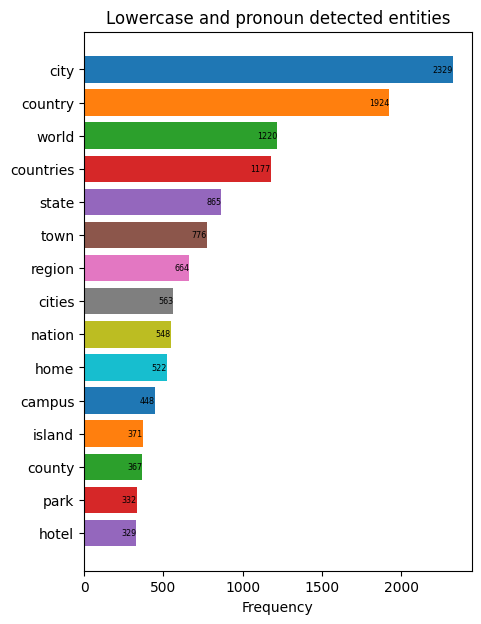

In [24]:
most_frequent = list(lower_case_freqs.items())[:15]
categories = [i[0] for i in most_frequent]
frequencies = [i[1] for i in most_frequent]

plot(frequencies, categories, "Frequency", "Lowercase and pronoun detected entities", "1.jpg")

20 20


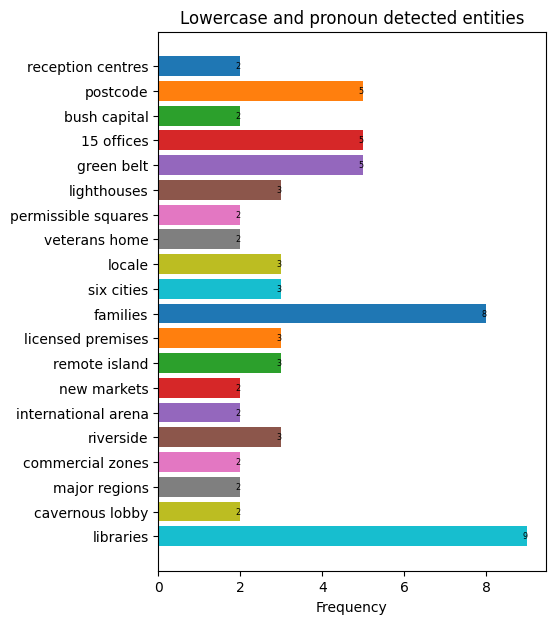

In [25]:
import random
least_frequent = [i for i in lower_case_freqs.items() if i[1] < 10 and i[1] > 1 and "@" not in i[0]]
random.seed(6556)
least_frequent = random.sample(least_frequent, k=20)

categories = [i[0] for i in least_frequent]
frequencies = [i[1] for i in least_frequent]
print(len(categories), len(frequencies))
plot(frequencies, categories, "Frequency", "Lowercase and pronoun detected entities", "2.jpg")

In [26]:
import re
import pandas as pd
def ignore_me(entity):
    return (entity.lower() in lower_case_freqs) and (entity.lower() not in non_lower_freqs)


total_entities, total_matches, not_found = match_entities_in_datasets(ignore_func=ignore_me)

  7%|▋         | 6811/100000 [00:12<02:41, 576.68it/s]

The final highlighted listing this week is an architectural-style home (built in 2009) located in the Franklin Elementary School district.


  9%|▉         | 9007/100000 [00:15<02:16, 664.26it/s]

unbalanced parenthesis at position 3 866) 645-7711 ||||| Dated: 5/28/ 2015 Quality Loan Service Corp. of Washington, as Trustee By: Tricia Moreno, Assistant Secretary Trustees Mailing Address: Quality Loan Service Corp. of Washington C/O Quality Loan Service Corp. 411 Ivy Street, San Diego, CA 92101 (866) 645-7711 Trustees Physical Address: Quality Loan Service Corp. of Washington 108 1 st Ave South, Suite 202 Seattle, WA 98104 (866) 925-0241 Sale Line: 916.939.0772 Or Login to:  TS No.
unbalanced parenthesis at position 3 866) 925-0241 ||||| Dated: 5/28/ 2015 Quality Loan Service Corp. of Washington, as Trustee By: Tricia Moreno, Assistant Secretary Trustees Mailing Address: Quality Loan Service Corp. of Washington C/O Quality Loan Service Corp. 411 Ivy Street, San Diego, CA 92101 (866) 645-7711 Trustees Physical Address: Quality Loan Service Corp. of Washington 108 1 st Ave South, Suite 202 Seattle, WA 98104 (866) 925-0241 Sale Line: 916.939.0772 Or Login to:  TS No.


 82%|████████▏ | 81783/100000 [02:07<00:34, 531.73it/s]

unterminated character set at position 23 Calcutta School of trop[ical Medicine ||||| Important Dates:Date & Time of Interview: 18-09-2015 at 11:00 am.Venue: Conference Room (4th Floor), Calcutta School of trop[ical Medicine, 108 C. R. Avenue, KOLKATA-700073.


 84%|████████▍ | 83940/100000 [02:10<00:27, 581.21it/s]

unterminated character set at position 0 [ ||||| The lord of [.
unterminated character set at position 0 [ ||||| The overseer of [.


 94%|█████████▍| 93853/100000 [02:26<00:10, 612.81it/s]

missing ), unterminated subpattern at position 0 ( ||||| ), and more.
unbalanced parenthesis at position 0 ) ||||| ), and more.


100%|█████████▉| 99700/100000 [02:35<00:00, 537.10it/s]

bad escape \l at position 1 '\lambdaIRIS' ||||| See a Platinum Stiletto Shoe on Top of 'λIRIS'.


100%|██████████| 100000/100000 [02:36<00:00, 638.89it/s]


In [29]:
total_matches / total_entities

0.590884460743763

In [30]:
total_matches, total_entities

(347859, 588709)

# Cutoffs

In [31]:
non_lower_freqs = {k: v for k, v in sorted(non_lower_freqs.items(), key=lambda item: item[1], reverse=True)}
for k in non_lower_freqs:
    if k in lower_case_freqs:
        non_lower_freqs[k] += lower_case_freqs[k]

In [ ]:
non_lower_freqs

In [33]:
CUT_OFF_PRECENTAGE = 20 #precent

In [34]:
end_idx = int(len(non_lower_freqs) * CUT_OFF_PRECENTAGE * 0.01)
cutted_off = {k:v for k, v in list(non_lower_freqs.items())[:end_idx]}
matches = {}

def match_entity(named_entity, spel_out, sentence):
    try:
        offsets = [(m.start(), m.end()) for m in re.finditer(named_entity.lower(), sentence.lower())]
        found_anything = False
        for mention in spel_out:
            start, end = tuple(mention["span"])
            for u, v in offsets:
                if max(u, start) < min(v, end):
                    return 1
        return 0
    except:
        return 0

for idx in tqdm(range(len(NER_filenames))):
    ner_out = read_file(NER_filenames[idx][0])
    spel_out = read_file(spel_filenames[idx][0])
    for i, sent in enumerate(nltk.sent_tokenize(read_file(signal_filenames[idx][0])["content"])):
        for ne in ner_out[i]:
            if ne.lower() not in cutted_off:
                continue
            matched = match_entity(ne, spel_out[i], sent)
            matches[ne.lower()] = matches.get(ne.lower(), 0) + matched


overlap_precentage = {}
for key, value in cutted_off.items():
    overlap_precentage[key] = matches.get(key, 0) / value



100%|██████████| 100000/100000 [02:31<00:00, 659.70it/s]


<ipython-input-39-4858f0f6ffb8>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5%', '10%', '15%', '20%'])


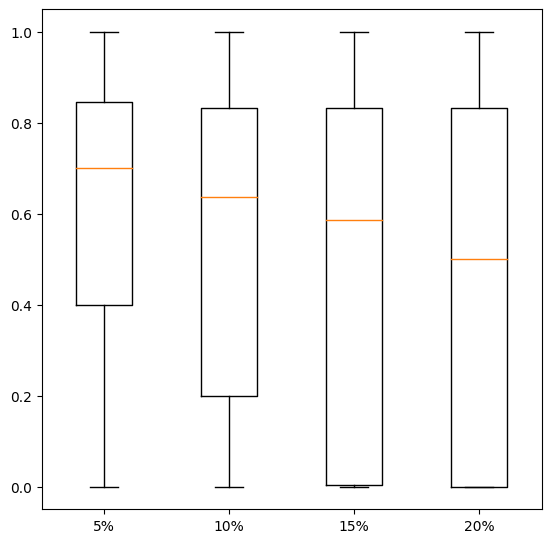

In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


overlap = [i[1] for i in list(overlap_precentage.items())]
data= [
       overlap[:int(len(overlap) * 0.25)],
       overlap[:int(len(overlap) * 0.5)],
       overlap[:int(len(overlap) * 0.75)],
       overlap[:int(len(overlap) * 1)]]
fig = plt.figure(figsize =(5, 5))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(['5%', '10%', '15%', '20%'])

# Creating plot
bp = ax.boxplot(data)

# show plot
plt.show()

In [ ]:
plt.savefig("loc_")

<Figure size 640x480 with 0 Axes>

In [41]:
import pickle

with open("overlap_loc.pkl", "wb") as f:
    pickle.dump(overlap_precentage, f)

In [42]:
!mv overlap_loc.pkl "/content/drive/MyDrive/Knowledge Graphs Course/Overlap"